In [73]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [74]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [75]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [76]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [77]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 10)
Y = np.random.uniform(-5, 5, 10)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [78]:
df

,x,y,z
0,-0.829780,-0.808055,-175.141124
1,2.203245,1.852195,-20.326731
2,-4.998856,-2.955478,-132.403402
3,-1.976674,3.781174,-39.397506
4,-3.532441,-4.726124,-149.789289
5,-4.076614,1.704675,-120.336105
6,-3.137398,-0.826952,-93.320859
7,-1.544393,0.586898,-131.648403
8,-1.032325,-3.596131,-207.066951
9,0.388167,-3.018985,-198.619945


In [79]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [81]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.05492156 -3.22922966]


In [82]:
df_sim = df.copy()

df_sim

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,4.054922,-3.22923,-174.869295,-0.271830
1,2.203245,1.852195,-20.326731,4.054922,-3.22923,-21.010718,0.683987
2,-4.998856,-2.955478,-132.403402,4.054922,-3.22923,-130.713501,-1.689901
3,-1.976674,3.781174,-39.397506,4.054922,-3.22923,-39.489907,0.092401
4,-3.532441,-4.726124,-149.789289,4.054922,-3.22923,-149.235939,-0.553350
5,-4.076614,1.704675,-120.336105,4.054922,-3.22923,-119.406325,-0.929780
6,-3.137398,-0.826952,-93.320859,4.054922,-3.22923,-92.230488,-1.090371
7,-1.544393,0.586898,-131.648403,4.054922,-3.22923,-131.211083,-0.437321
8,-1.032325,-3.596131,-207.066951,4.054922,-3.22923,-207.199510,0.132559
9,0.388167,-3.018985,-198.619945,4.054922,-3.22923,-199.137869,0.517924


In [83]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,4.054922,-3.22923,-174.869295,-0.271830
1,2.203245,1.852195,-20.326731,4.054922,-3.22923,-21.010718,0.683987
2,-4.998856,-2.955478,-132.403402,4.054922,-3.22923,-130.713501,-1.689901
3,-1.976674,3.781174,-39.397506,4.054922,-3.22923,-39.489907,0.092401
4,-3.532441,-4.726124,-149.789289,4.054922,-3.22923,-149.235939,-0.553350
5,-4.076614,1.704675,-120.336105,4.054922,-3.22923,-119.406325,-0.929780
6,-3.137398,-0.826952,-93.320859,4.054922,-3.22923,-92.230488,-1.090371
7,-1.544393,0.586898,-131.648403,4.054922,-3.22923,-131.211083,-0.437321
8,-1.032325,-3.596131,-207.066951,4.054922,-3.22923,-207.199510,0.132559
9,0.388167,-3.018985,-198.619945,4.054922,-3.22923,-199.137869,0.517924


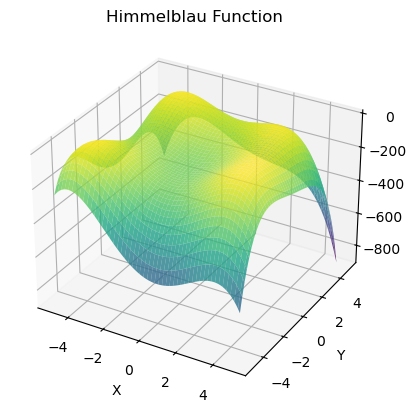

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Himmelblau Function')

# Show the plot
plt.show()

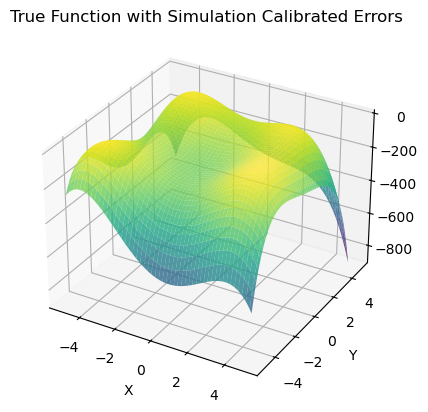

In [85]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [86]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [87]:
df_new = pd.DataFrame

In [88]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)

    # Define probability function based on model uncertainty
    def p(x):
        x_reshaped = x.reshape(1, -1)
        mean, std = mc_dropout_predictions(best_model, x_reshaped)
        mean = mean.ravel() 
        std = std.ravel() 
         # Check if x stays within x1_range and x2_range
        if x_reshaped[0, 0] >= np.min(x1_range) and x_reshaped[0, 0] <= np.max(x1_range) and \
        x_reshaped[0, 1] >= np.min(x2_range) and x_reshaped[0, 1] <= np.max(x2_range):
            # Compute the upper bound of the 95% confidence interval and compare with the median
            return np.max([mean[0] + 1.96 * std[0] - df['sim_z'].median(), 0])
        else:
            return 0  # Return 0 if the point is outside the valid input space

    # Metropolis step proposal distribution N(0,sig**2)
    def metropolis_step(x, sig):
        prop_x = x + np.random.normal(0, sig, size=x.shape)
        u = np.random.uniform(0, 1)
        if u < np.min([1.0, p(prop_x) / p(x)]):
            return prop_x
        else:
            return x

    # Metropolis-Hastings Sampler
    def mh_sampler(sig, sample_size, burn_in, lag):
        x = np.array([[df["x"].loc[np.argmax(df["sim_z"])], df["y"].loc[np.argmax(df["sim_z"])]]])
        for i in range(burn_in):
            x = metropolis_step(x, sig)
        samples = x
        for i in range(sample_size - 1):
            for j in range(lag):
                x = metropolis_step(x, sig)
            samples = np.vstack((samples, x))
        return samples

    # Generate new points using MH sampler
    sig = 2 
    sample_size = 10
    burn_in = 150
    lag = 15
    new_points = mh_sampler(sig, sample_size, burn_in, lag)

    # Convert new points to dataframe
    df2 = pd.DataFrame(new_points, columns=['x', 'y'])
    temp_df =  df2

    # Add simulated responses for new points
    df2['z'] = benchmark(df2['x'], df2['y']) + ran_err(sample_size, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2['x'], df2['y'], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    # Add new points to original dataframe
    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Produce Meshgrid of results with C.I.
    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    x_grid_scaled = scaler_x.transform(x_grid)

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)
    
    # Plotting the predictions with confidence intervals and next sampling points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshape predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)


    # Plot the mean prediction surface
    ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    # Plot the upper and lower confidence intervals
    ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Ensure that the input data shape matches the model's expected input
    input_data = df2[['x', 'y']].values  # Select relevant columns for input
    predictions = best_model.predict(input_data)  # Predict with the model

    # If the predictions are in a 2D array, flatten to 1D for a single-column addition
    temp_df["z"] = predictions.ravel()

    ax.scatter(temp_df["x"], temp_df["y"], temp_df["z"], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    ax.legend(loc='upper left')

    # Show the plot
    plt.show()
    return df, df2


Best hyperparameters:
num_layers: 7
num_units: 126
learning_rate: 0.003370740904091794
dropout_rate: 0.24509090456165214
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 19464.3184
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19419.8848
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19359.6777
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19207.7598
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18969.7969
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18411.3691
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17214.8457
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15552.3926
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12883.8838
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8024.7061
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7719.7798
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9005.5547
Epoch 13/200
1/1 ━━━━━━━━

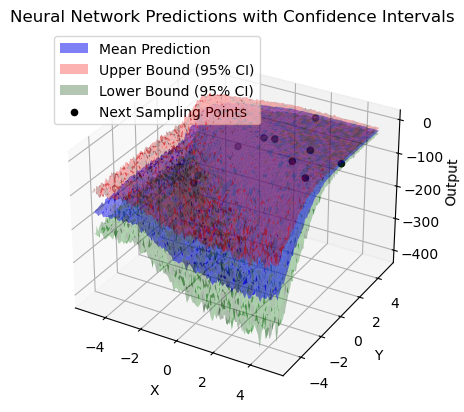

          x         y           z         a        b       sim_z      diff
0  4.989098  1.073002  -22.253695  4.054922 -3.22923 -224.473963 -0.185898
1  1.014992  1.826782  -27.103930  4.054922 -3.22923  -73.282430 -0.049196
2  3.877451 -0.393277  -42.247921  4.054922 -3.22923  -22.079513  0.048669
3  3.113737  1.511200  -21.939058  4.054922 -3.22923   -2.464253 -0.127674
4 -1.103560  1.981461  -84.467171  4.054922 -3.22923  -78.403475  0.116228
5 -2.362744 -0.103700 -159.203201  4.054922 -3.22923 -117.934008 -0.057937
6 -2.946212  1.210638 -179.780029  4.054922 -3.22923  -73.275889  0.184926
7  0.328962  1.998270  -38.448837  4.054922 -3.22923  -86.275832  0.077943
8  2.814012  0.284928  -27.612633  4.054922 -3.22923  -24.616295 -0.118096
9  1.770967  4.550247  -22.032206  4.054922 -3.22923 -250.447860  0.086455


In [89]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.014570602706749413
dropout_rate: 0.0
batch_size: 22
epochs: 118
Epoch 1/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 17350.5996
Epoch 2/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17148.7422
Epoch 3/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15751.3027
Epoch 4/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9786.8721
Epoch 5/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13341.6904
Epoch 6/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5645.8623
Epoch 7/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9254.1377
Epoch 8/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10835.7891
Epoch 9/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 11006.7031
Epoch 10/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10108.2988
Epoch 11/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8081.6030
Epoch 12/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5183.9546
Epoch 13/118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

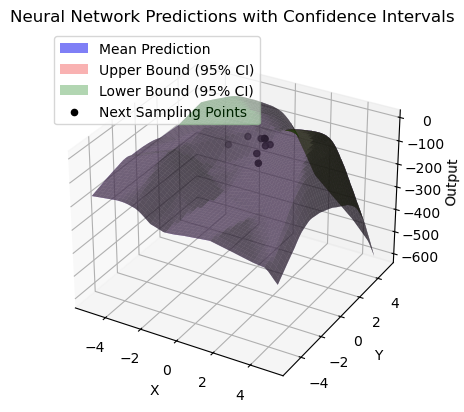

In [90]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.009996381302598528
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16033.6523
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15997.1387 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13276.1611 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13424.1943 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10743.0830 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7638.7100 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4666.6729 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3941.0034 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4250.3335 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4668.8525 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4794.5234 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3474.6587 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

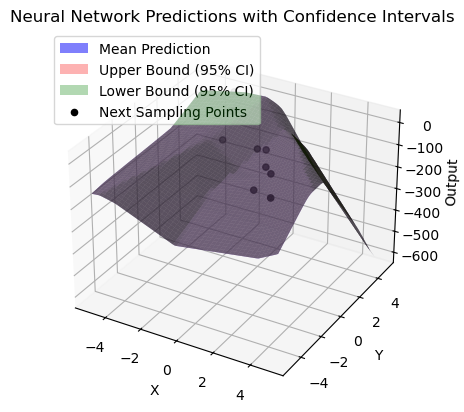

In [91]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 128
learning_rate: 0.05602806788279885
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13975.9141
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7574.2466 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10276.2490
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7096.5674 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12192.5908 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13457.2461 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12432.3984 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14110.5596 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11196.1436 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7241.7793 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11149.9189
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3393.2971 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

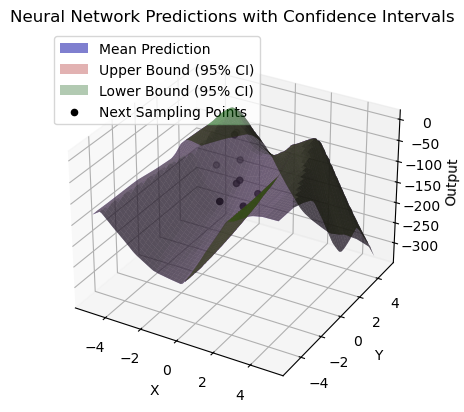

In [92]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.011607479631856508
dropout_rate: 0.0
batch_size: 20
epochs: 166
Epoch 1/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21473.5156
Epoch 2/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8450.9072  
Epoch 3/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5892.3804 
Epoch 4/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5939.9067 
Epoch 5/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7748.0322 
Epoch 6/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7453.0400 
Epoch 7/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7236.5024 
Epoch 8/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5940.0264 
Epoch 9/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4085.8257 
Epoch 10/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4789.9297 
Epoch 11/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3232.7615 
Epoch 12/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6381.3486 
Epoch 13/166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

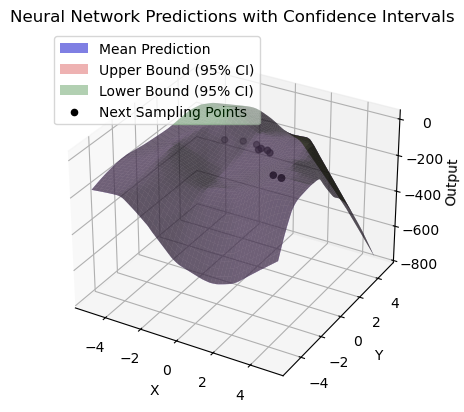

In [93]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 8
num_units: 50
learning_rate: 0.000987759137401478
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 16674.3477
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17068.4961 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17665.0312 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18254.5059 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16377.8652 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20926.6035 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16184.6943 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14759.9258 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18677.5000 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15413.0957 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20172.9316 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16844.4375 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

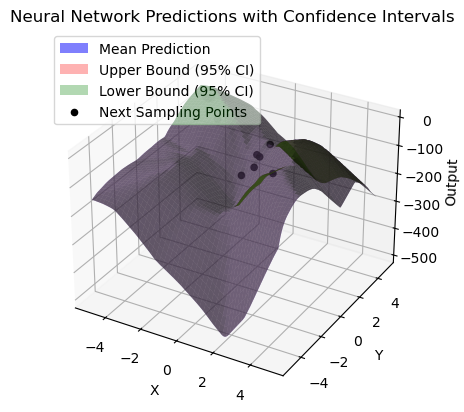

          x         y          z         a        b       sim_z      diff
0 -2.377765  2.191210 -41.080147  4.054922 -3.22923  -31.107161  0.185885
1 -4.037470  4.105559 -49.107883  4.054922 -3.22923 -123.035411  0.631571
2 -4.249238  4.206188 -50.619957  4.054922 -3.22923 -169.094670  0.669148
3  1.026010 -1.390866 -70.375664  4.054922 -3.22923 -144.916304 -0.003477
4  1.402955 -0.597047 -17.077822  4.054922 -3.22923 -120.183797 -0.027010
5 -3.956686  4.271106 -51.892597  4.054922 -3.22923 -133.485969  0.708535
6  1.249030  0.954075 -30.864004  4.054922 -3.22923  -95.395417 -0.043246
7  1.401724 -0.328672 -32.345142  4.054922 -3.22923 -117.817254  0.069187
8  2.534149 -1.084904 -46.226219  4.054922 -3.22923  -42.953468  0.108146
9  1.831517 -1.616825 -21.515171  4.054922 -3.22923  -92.410485  0.081577


In [94]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.0040725384152309405
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 18751.8613
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14832.1309 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14501.3574 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8052.4663  
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7790.0972 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7917.4150  
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7866.5415 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4833.0356 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5229.4165 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4559.5894 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5635.8394 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4459.4761 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

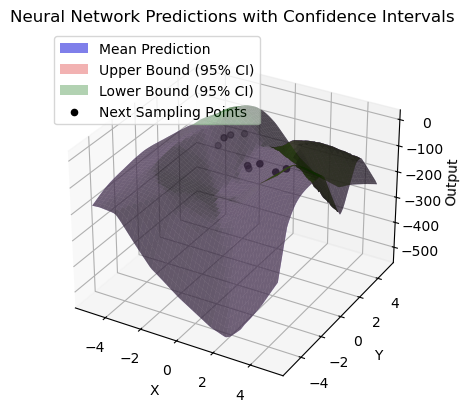

          x         y          z         a        b       sim_z      diff
0  3.252453 -1.098266  -8.955634  4.054922 -3.22923   -8.892801  0.090022
1 -1.709243  1.107220 -87.843300  4.054922 -3.22923 -104.700054  0.173982
2 -0.984371  1.067880 -33.063011  4.054922 -3.22923 -127.249493  0.098830
3 -0.727094  1.953090 -51.966156  4.054922 -3.22923  -87.980055  0.043868
4 -1.546389  1.399221 -64.698059  4.054922 -3.22923  -95.502748  0.154958
5 -1.546389  1.399221 -64.698059  4.054922 -3.22923  -95.502748  0.157993
6  0.586637  0.074132 -98.055428  4.054922 -3.22923 -153.050547 -0.117400
7  1.020643 -0.796871 -49.698082  4.054922 -3.22923 -144.282962  0.010011
8  2.972813 -1.604994  -9.608630  4.054922 -3.22923  -16.476723  0.153990
9  1.985475 -1.346719  -6.510178  4.054922 -3.22923  -80.994468  0.015017


In [95]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

In [96]:
df_new

,x,y,z,a,b,sim_z,diff
0,3.252453,-1.098266,-8.955634,4.054922,-3.22923,-8.892801,0.090022
1,-1.709243,1.107220,-87.843300,4.054922,-3.22923,-104.700054,0.173982
2,-0.984371,1.067880,-33.063011,4.054922,-3.22923,-127.249493,0.098830
3,-0.727094,1.953090,-51.966156,4.054922,-3.22923,-87.980055,0.043868
4,-1.546389,1.399221,-64.698059,4.054922,-3.22923,-95.502748,0.154958
5,-1.546389,1.399221,-64.698059,4.054922,-3.22923,-95.502748,0.157993
6,0.586637,0.074132,-98.055428,4.054922,-3.22923,-153.050547,-0.117400
7,1.020643,-0.796871,-49.698082,4.054922,-3.22923,-144.282962,0.010011
8,2.972813,-1.604994,-9.608630,4.054922,-3.22923,-16.476723,0.153990
9,1.985475,-1.346719,-6.510178,4.054922,-3.22923,-80.994468,0.015017


In [97]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,4.054922,-3.22923,-174.869295,-0.271830
1,2.203245,1.852195,-20.326731,4.054922,-3.22923,-21.010718,0.683987
2,-4.998856,-2.955478,-132.403402,4.054922,-3.22923,-130.713501,-1.689901
3,-1.976674,3.781174,-39.397506,4.054922,-3.22923,-39.489907,0.092401
4,-3.532441,-4.726124,-149.789289,4.054922,-3.22923,-149.235939,-0.553350
5,-4.076614,1.704675,-120.336105,4.054922,-3.22923,-119.406325,-0.929780
6,-3.137398,-0.826952,-93.320859,4.054922,-3.22923,-92.230488,-1.090371
7,-1.544393,0.586898,-131.648403,4.054922,-3.22923,-131.211083,-0.437321
8,-1.032325,-3.596131,-207.066951,4.054922,-3.22923,-207.199510,0.132559
9,0.388167,-3.018985,-198.619945,4.054922,-3.22923,-199.137869,0.517924


In [98]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.3545680945531956


In [99]:
df = pd.concat([df, df_new], ignore_index=True)
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,4.054922,-3.22923,-174.869295,-0.271830
1,2.203245,1.852195,-20.326731,4.054922,-3.22923,-21.010718,0.683987
2,-4.998856,-2.955478,-132.403402,4.054922,-3.22923,-130.713501,-1.689901
3,-1.976674,3.781174,-39.397506,4.054922,-3.22923,-39.489907,0.092401
4,-3.532441,-4.726124,-149.789289,4.054922,-3.22923,-149.235939,-0.553350
5,-4.076614,1.704675,-120.336105,4.054922,-3.22923,-119.406325,-0.929780
6,-3.137398,-0.826952,-93.320859,4.054922,-3.22923,-92.230488,-1.090371
7,-1.544393,0.586898,-131.648403,4.054922,-3.22923,-131.211083,-0.437321
8,-1.032325,-3.596131,-207.066951,4.054922,-3.22923,-207.199510,0.132559
9,0.388167,-3.018985,-198.619945,4.054922,-3.22923,-199.137869,0.517924


In [100]:
df = df.iloc[:, :-4]
df

,x,y,z
0,-0.829780,-0.808055,-175.141124
1,2.203245,1.852195,-20.326731
2,-4.998856,-2.955478,-132.403402
3,-1.976674,3.781174,-39.397506
4,-3.532441,-4.726124,-149.789289
5,-4.076614,1.704675,-120.336105
6,-3.137398,-0.826952,-93.320859
7,-1.544393,0.586898,-131.648403
8,-1.032325,-3.596131,-207.066951
9,0.388167,-3.018985,-198.619945


In [101]:
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.05492156 -3.22922966]


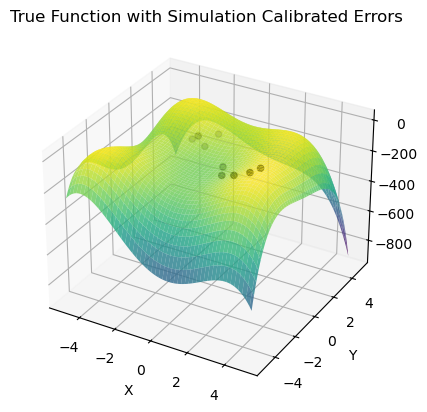

In [102]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)


# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [103]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,4.054922,-3.22923,-174.926560,-0.214564
1,2.203245,1.852195,-20.326731,4.054922,-3.22923,-20.328021,0.001290
2,-4.998856,-2.955478,-132.403402,4.054922,-3.22923,-130.539482,-1.863920
3,-1.976674,3.781174,-39.397506,4.054922,-3.22923,-38.285383,-1.112123
4,-3.532441,-4.726124,-149.789289,4.054922,-3.22923,-147.418145,-2.371144
5,-4.076614,1.704675,-120.336105,4.054922,-3.22923,-119.707417,-0.628687
6,-3.137398,-0.826952,-93.320859,4.054922,-3.22923,-92.625792,-0.695067
7,-1.544393,0.586898,-131.648403,4.054922,-3.22923,-131.406399,-0.242004
8,-1.032325,-3.596131,-207.066951,4.054922,-3.22923,-205.998538,-1.068413
9,0.388167,-3.018985,-198.619945,4.054922,-3.22923,-198.127345,-0.492600
